In [1]:
import numpy as np
from parallelReservoir import parallelESN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.integrate import ode
from scipy.interpolate import UnivariateSpline

In [2]:
def lorenz(t, M, s, r, b):
    x, y, z = M
    f = [s*(y - x), r*x - y - x*z, x*y - b*z]
    return f

solver = ode(lorenz)
solver.set_integrator('dop853')

s = 10
r = 28
b = 8/3.0
solver.set_f_params(s,r,b)

t0 = 0.0
M0 = [0., 1., 1.05]
solver.set_initial_value(M0, t0)

t1 = 400
N = 40000
t = np.linspace(t0, t1, N)
sol = np.empty((N, 3))
sol[0] = M0

k = 1
while solver.successful() and solver.t < t1:
    solver.integrate(t[k])
    sol[k] = solver.y
    k += 1

In [3]:
rlist = []
num_r = 3
for n in range(num_r):
    rlist.append(parallelESN(n_outputs = 3, 
          n_reservoir = 600,
          square = True,
          spectral_radius = 0.7, sparsity=0.7,
          silent = False))
    print(n)

0
1
2


In [4]:
trainlen = 30000
future = 10000
Lambda = 0.9056
F = Lambda/100
tlist = np.array(range(0,future))*F
time = np.array(range(0,future))/100

sol_data1 = []
# sol_data1.append(np.hstack((sol[:trainlen,2:],sol[:trainlen,0:2])))
# sol_data1.append(sol[:trainlen,:])
# sol_data1.append(np.hstack((sol[:trainlen,1:],sol[:trainlen,0:1])))
sol_data1.append(sol[:trainlen,:])
sol_data1.append(sol[:trainlen,:])
sol_data1.append(sol[:trainlen,:])
# (30000,3)

sol_data2 = []
for i in range(num_r):
    sol_data2.append(sol[:trainlen,i:i+1])
    #(30000,1)

In [5]:
for i in range(num_r):
    pred = rlist[i].fit(sol_data1[i],sol_data2[i])
    print(i)

training error:
15.539526041743574
0
training error:
15.732608810342658
1
training error:
21.836394142500563
2


In [6]:
lastout = []
for i in range(num_r):
    lastout.append(rlist[i].lastoutput)
output = np.vstack([np.reshape(lastout,-1), np.zeros((future, num_r))])
inp = np.zeros((3, 3))
outp = np.zeros((3, 1))
for j in range(future):
#     inp[0] = np.hstack((output[j,2:],output[j,0:2]))
#     inp[1] = output[j]
#     inp[2] = np.hstack((output[j,1:],output[j,0:1]))
    inp[0] = output[j]
    inp[1] = output[j]
    inp[2] = output[j]
    for i in range(num_r):
        outp[i] = rlist[i].predictnext(inp[i])
    output[j+1,:]=np.reshape(outp,-1)
prediction = output[1:]
print("test error: \n"+str(np.sqrt(np.mean((prediction - sol[trainlen:trainlen+future])**2))))

test error: 
12.089441911022584


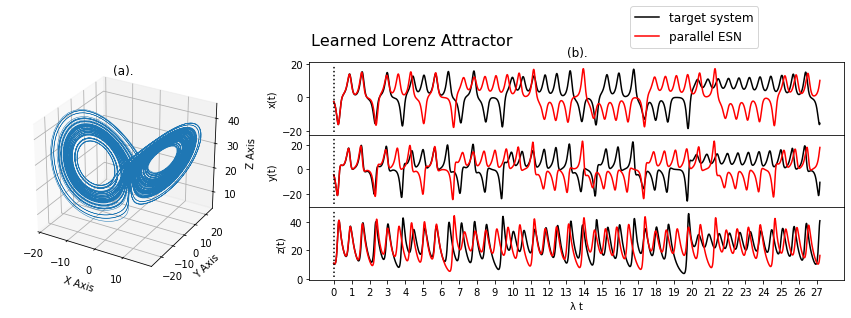

In [7]:
fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3,wspace=0.3,hspace=0.)

plta = fig.add_subplot(gs[:, 0],projection='3d')
plta.set_xlabel("X Axis")
plta.set_ylabel("Y Axis")
plta.set_zlabel("Z Axis")
plta.set_title("(a).")
plta.plot(prediction[:,0], prediction[:,1], prediction[:,2], lw=0.5)

pltb = fig.add_subplot(gs[0, 1:])
pltb.plot(tlist[0:3000],sol[trainlen:trainlen+3000,0],'k',label="target system")
pltb.plot(tlist[0:3000],prediction[0:3000,0],'r', label="parallel ESN")
lo,hi = pltb.get_ylim()
pltb.plot([tlist[0],tlist[0]],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
pltb.set_ylabel("x(t)")
pltb.set_title("(b).")
plt.setp(pltb.get_xticklabels(), visible=False)


pltc = fig.add_subplot(gs[1, 1:], sharex=pltb)
pltc.plot(tlist[0:3000],sol[trainlen:trainlen+3000,1],'k',label="target system")
pltc.plot(tlist[0:3000],prediction[0:3000,1],'r', label="parallel ESN")
lo1,hi1 = pltc.get_ylim()
pltc.plot([tlist[0],tlist[0]],[lo1+np.spacing(1),hi1-np.spacing(1)],'k:')
pltc.set_ylabel("y(t)")
plt.setp(pltc.get_xticklabels(), visible=False)


pltd = fig.add_subplot(gs[2, 1:], sharex=pltb)
pltd.plot(tlist[0:3000],sol[trainlen:trainlen+3000,2],'k',label="target system")
pltd.plot(tlist[0:3000],prediction[0:3000,2],'r', label="parallel ESN")
lo2,hi2 = pltd.get_ylim()
pltd.plot([tlist[0],tlist[0]],[lo2+np.spacing(1),hi2-np.spacing(1)],'k:')
plt.xticks(range(28))
pltd.set_ylabel("z(t)")
pltd.set_xlabel("\u03BB t")


pltd.legend(loc=(0.6,3.2),fontsize='large')


fig.suptitle("Learned Lorenz Attractor", fontsize=16)
fig.set_size_inches(w=15,h=4)